In [9]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

In [3]:
p = sm.Project.objects.get(pk=196)

In [4]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [12]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [13]:
ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

In [14]:
print(len(ttweets))

233059


---

## Language from BaseModel

In [15]:
random.seed(123)
test_texts = tm.Status.objects.filter(
    id__in=random.sample(ttweets, 1000)
).values_list('text', 'lang')

In [16]:
df_test = pd.DataFrame(list(test_texts), columns=['text', 'lang'])

In [18]:
is_de = df_test["lang"]=="de"
df_de = df_test[is_de]

In [19]:
df_de.head()

,text,lang
0,Atom- und Kohleausstieg gleichzeitig geht nich...,de
1,@ntvde Ich hätte zuerst Kohleausstieg bzw. Aus...,de
2,So eindeutig/konsequent Schwarz/Gelb Energiewe...,de
3,"Schade. Der ""Kohleausstieg bis 2030"" hat nur f...",de
4,SRU Vorsitzender empfiehlt Kohleausstieg\nZEIT...,de


In [10]:
#df_test.to_csv("df_test.csv")

In [13]:
#df_de.to_csv('df_de.csv')

---

## Filter for relevant keywords

filter tweets in 'Kohle' set using relevant hashtags, then add tweets from other TS objects to joint dataset?  

In [7]:
# Q lookup must precede any keyword argument
ktf = tm.Status.objects.filter(
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#endegelaende') |
    Q(text__icontains = '#hambacherwald') |
    Q(text__icontains = '#lausitz') |
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klimakrise') |
    Q(text__icontains = '#klima')
)
#.filter(text__icontains="Kohle")

ktf.count()

1132554

In [8]:
ktff = ktf.filter(
    text__icontains="Kohle"
).filter(
    created_at__lte=end_date
)
ktff.count()

77733

In [20]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
)

### combining tweets

In [21]:
qcomb = ktff | query2

In [22]:
qcomb.count()

350804

In [25]:
qcomb_ids = set(qcomb.values_list('id',flat=True))

---

## Sentiment Analysis

In [30]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [61]:
def get_senti_score(tweet):
    """gets the score of a tweet from SentiWS"""
    scores = []
    for token in tweet:
        score = token._.sentiws
        if score is not None:
            scores.append(score)
    
    if sum(scores) != 0:
        return sum(scores)/len(tweet)
    else:
        return 0

### testing on small set

In [47]:
df_de.iloc[2]['text']

'So eindeutig/konsequent Schwarz/Gelb Energiewende blockiert, so unentschlossen ist SPD in Sachen Kohleausstieg und Offshore-Wahnsinn. Schade'

In [51]:
len(df_de.iloc[2]['text'].split())

15

In [53]:
doc = nlp(df_de.iloc[2]['text'])
for token in doc: 
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))

So, None, ADV
eindeutig/konsequent, None, VERB
Schwarz/Gelb, None, PROPN
Energiewende, None, NOUN
blockiert, -0.3459, VERB
,, None, PUNCT
so, None, ADV
unentschlossen, None, ADJ
ist, None, AUX
SPD, None, PROPN
in, None, ADP
Sachen, None, NOUN
Kohleausstieg, None, NOUN
und, None, CONJ
Offshore-Wahnsinn, None, NOUN
., None, PUNCT
Schade, -0.0048, ADJ


In [62]:
get_senti_score(doc)

-0.020629411764705882

In [63]:
tweet_scores = []
for i in df_de.index:
    entry = df_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    tweet_scores.append(tweet_score)

In [64]:
df_de['score'] = tweet_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
#df_de.to_csv("df_de_scores2.csv")

In [65]:
most_neg = df_de.sort_values(by=['score'])[0:5]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

"Die Garantie fehlt" https://t.co/e0J68h2Aez #hambibleibt
#Kohleausstieg - Zukunft des HambacherForst weiter unklar https://t.co/oHnJ0j8sTi
Uneinigkeit beim G20-Gipfel https://t.co/6UtjS3QOch #hambibleibt
@bmel @JuliaKloeckner Elende Heuchler. #Hambibleibt
16:36 Eine Person wird aus der Traverse geholt. Geräumte Person vom Tripod in schlechter körperlicher Verfassung, Schuld ist gerissener Geduldsfaden der Polizei – Räumungen werden gewaltätiger.
#hambibleibt #HambacherForst


In [67]:
most_pos = df_de.sort_values(by=['score'], ascending=False)[0:5]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Tolle Neuigkeiten! #hambibleibt https://t.co/cysxrRVBuP
Guten Morgen allerseits. Wünsche allen auf dem Weg zum #hambacherforst eine sichere und angenehme Anfahrt. Viel Erfolg heute. #hambibleibt
Ein wohl verdienter Feierabend! Tolle Menschen :)

 #HambacherForst #HambiBleibt #AktionUnterholz #BuirerFuerBuir https://t.co/eek3hMHJmh
Spannender Augenzeugenbericht zum Tagebau #hambach dem #Hambacherforst und dessen entwicklung #Hambibleibt https://t.co/jSylMYyFvL
Was für eine tolle Idee. Kommt schon! #hambibleibt https://t.co/X6o0gNmP76


---

### Actual

In [68]:
texts = tm.Status.objects.filter(
    id__in=qcomb_ids
).values_list('id','created_at','text', 'lang')

In [69]:
df_texts = pd.DataFrame(list(texts), columns=['id','created_at','text', 'lang'])

In [70]:
is_de = df_texts["lang"]=="de"
texts_de = df_texts[is_de]

In [71]:
texts_scores = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    texts_scores.append(tweet_score)

In [72]:
texts_de['score'] = texts_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
texts_de.to_csv('texts_de_20200218.csv')

---

### Results

In [4]:
#texts_de = pd.read_csv('texts_de.csv', index_col=[0])

In [74]:
# Style
sns.set_style('whitegrid')

In [5]:
# convert to datetime object
texts_de['created_at'] =  pd.to_datetime(texts_de['created_at'])

In [75]:
texts_de.head()

,id,created_at,text,lang,score
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.000174
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.020047
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.008653
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000


In [76]:
len(texts_de)

240927

In [77]:
average_score = sum(texts_de['score'])/len(texts_de['score'])
average_score

-0.0012697723598929813

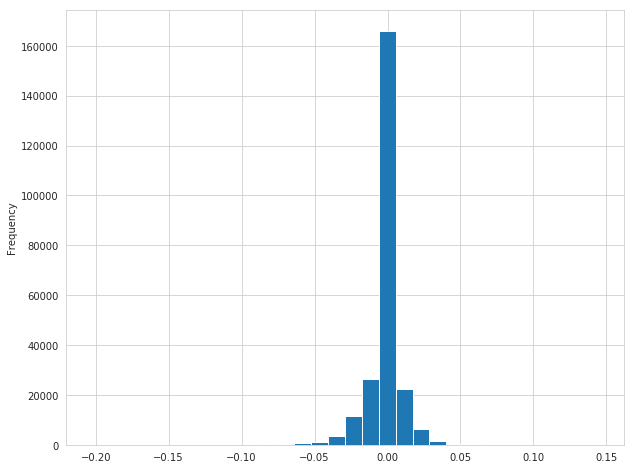

In [82]:
fig, ax = plt.subplots(figsize=(10,8))

texts_de['score'].plot.hist(bins=30)

plt.show()

In [83]:
most_neg = texts_de.sort_values(by=['score'])[0:10]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

Schwacher Windkraft-Ausbau gefährdet Kohleausstieg - https://t.co/1Neg78M4lY https://t.co/DAuJhcBaoq
Fehlerhaften Kohleausstieg vermeiden: https://t.co/pB5RGKJY0B
Steuerzahlerbund gegen Schulden https://t.co/x3wupX6vNI #hambibleibt
Plastikmüll ist tödliche Gefahr https://t.co/TKeeCK0ao4 #Radreise #hambibleibt
Plastikmüll ist tödliche Gefahr https://t.co/TKeeCK0ao4 #Radreise #hambibleibt
Das ist verdammt billig #HambiBleibt
das ist einfach unfair und gemein.
#hambibleibt https://t.co/RC9NQelIV4
Kohlekommission: Opposition unerwünscht https://t.co/kCzDmIN202
@dpa @RheinZeitung Schlechter Schachzug, ganz schlechter Schachzug. #hambibleibt
Kritik am Koalitionsvertrag: Klarer Kohleausstieg fehlt https://t.co/36EFmRMPPg


In [84]:
most_pos = texts_de.sort_values(by=['score'], ascending=False)[0:10]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Wunderbar! #hambibleibt https://t.co/EFNyFZ0c0d
Aufatmen und riesige Freude! #hambibleibt https://t.co/rWCgwWAiYa
Große Freude! #Hambibleibt! https://t.co/flo1SlWGPl https://t.co/NVJeaAjpxn
#Kohleausstieg feiern bei bestem Wetter https://t.co/Qu8C9y4T5y
Ganz wunderbar diese Bechsteinfledermäuse #hambibleibt
Besonders wertvoll mit dem Zusatz #hambibleibt https://t.co/DrPOkrvjta
ja wunderbar #Kohleausstieg super Sache,sofort https://t.co/awhej2y8CA bitte_dringlichst_zu_handeln.#klimawandel https://t.co/CyiTbcDqr7
Freude für den #HambiBleibt https://t.co/zRGTrSiuFZ
Wunderbar. #hambibleibt #HambacherWald https://t.co/kOWL5T8RjP
Wunderbar dieses kreative Engagement miterleben zu dürfen. #Hambilebt #Hambibleibt #StopKohle https://t.co/V6SYutp7jF


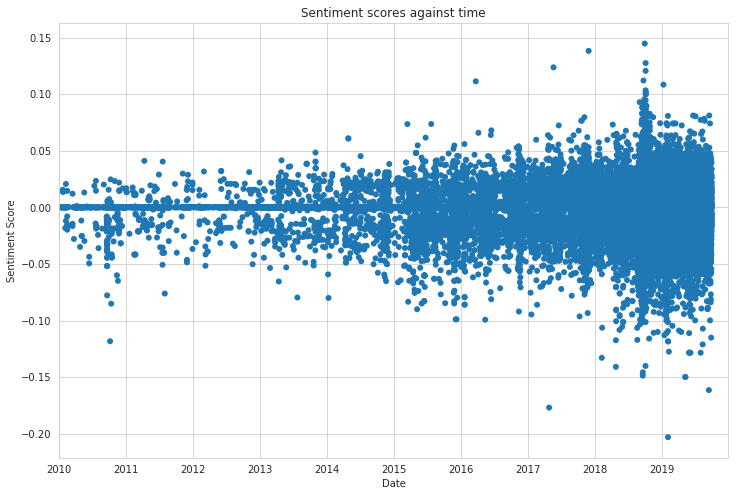

In [87]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de['created_at'], texts_de['score'], edgecolor='', ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2010-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Sentiment Score", title="Sentiment scores against time")
plt.show()

In [88]:
texts_de_daily = texts_de.groupby(pd.Grouper(key='created_at',freq='D'))['score'].mean()

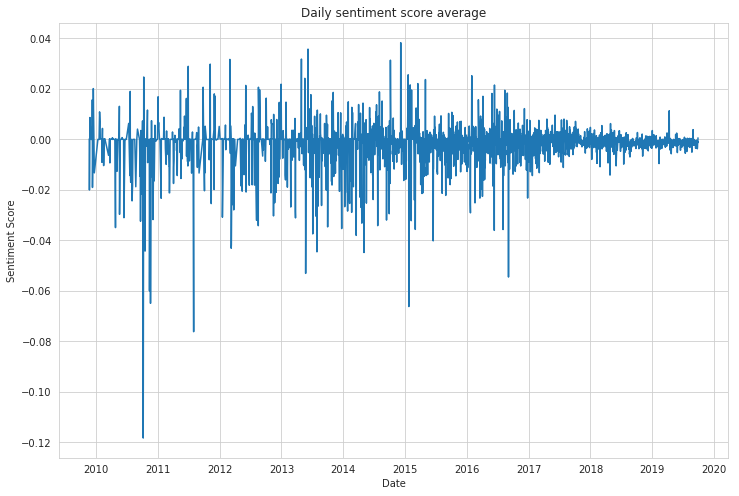

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Daily sentiment score average")
plt.show()
fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [90]:
texts_de_monthly = texts_de.groupby(pd.Grouper(key='created_at',freq='M'))['score'].mean()

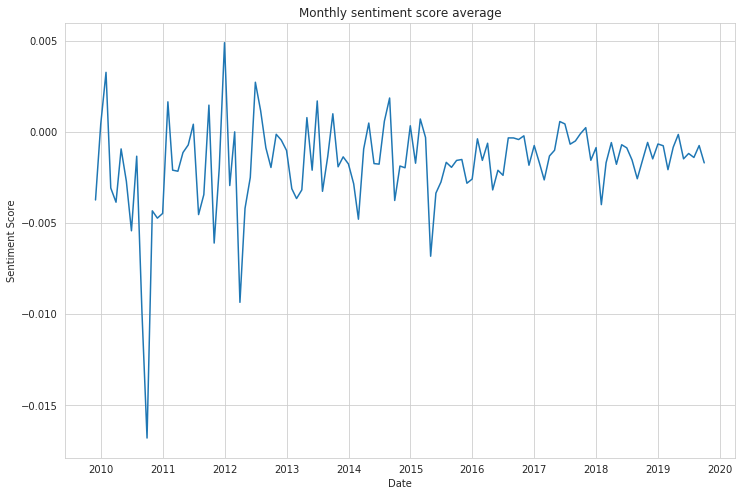

In [94]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_monthly.index, texts_de_monthly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Monthly sentiment score average")
plt.show()
fig.savefig('plots/monthlyavgsenti.png', dpi=300)

In [95]:
texts_de_yearly = texts_de.groupby(pd.Grouper(key='created_at',freq='Y'))['score'].mean()

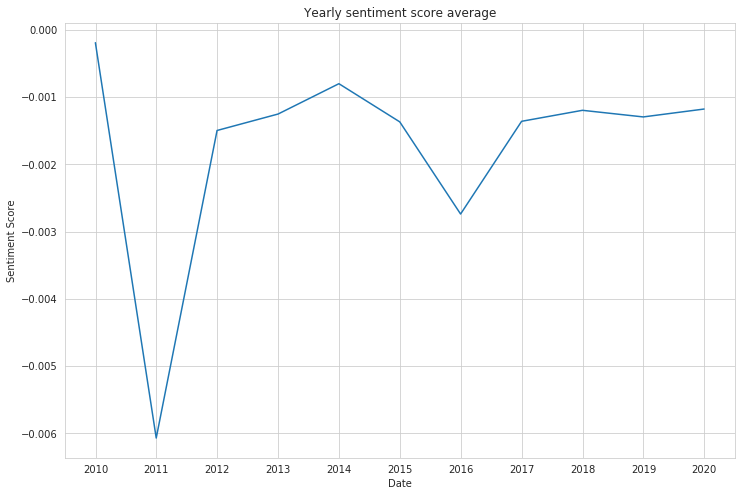

In [97]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_yearly.index, texts_de_yearly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Yearly sentiment score average")
plt.show()
fig.savefig('plots/yearlyavgsenti.png', dpi=300)